# Unsupervised GraphSAGE on the Cora citation dataset

In this example, we build  the unsupervised GraphSAGE model. This extension heavily borrows from the supervised GraphSAGE implementation[GraphSAGE](http://snap.stanford.edu/graphsage/). The Cora dataset is used to test the process of unsupervised learning with GraphgSAGE. 

### Unsupervised GraphSAGE:

To address this problem, we build a model with the following architecture.
First the GraphSAGE model is trained by feeding it a training set of postive links (target, context) pairs and equal number of negative (target, context) pairs. The model first generates teh embeddings for the each target and each context. 
These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. 

The obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. 
The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

In [49]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification

import keras 
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar

### Loading the CORA network data

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [50]:
data_dir = "~/data/cora"

Load the graph from edgelist

In [51]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"  # set the edge type

In [52]:
G = nx.from_pandas_edgelist(edgelist, edge_attr="label")

Load the features and subject for the nodes

In [53]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

Define a set of node features that will be used by the model as the difference between the set of all node features and a list of user-defined node attributes to ignore:

In [54]:
ignore_attr = []
feature_names = sorted(set(column_names) - set(ignore_attr))

We need to convert node features that will be used by the model to numeric values that are required for GraphSAGE input. Note that all node features in the Cora dataset, except the categorical "subject" feature, are already numeric, and don't require the conversion.

In [55]:
if "subject" in feature_names:
    # Convert node features to numeric vectors
    feature_encoding = feature_extraction.DictVectorizer(sparse=False)
    node_features = feature_encoding.fit_transform(
        node_data[feature_names].to_dict("records")
    )
else:  # node features are already numeric, no further conversion is needed
    node_features = node_data[feature_names].values

Add node data to G:

In [56]:
for nid, f in zip(node_data.index, node_features):
    G.node[nid][globalvar.TYPE_ATTR_NAME] = "paper"  # specify node type
    G.node[nid]["feature"] = f

We aim to learn the embeddings of nodes in a graph in an unsupervised fashion. 

From the original graph G, build a training set of (target, context) pairs by randomly sampling subset of node pairs (equal number of true and false citation links:
Positive (target, context) pairs: 
For each node(target), extract its 1-hop neighborhood. Sample k neighbors unifomly at random. These are the positive (target, context) links.
Negative (target, context) pairs: 
For each node(target), from all the nodes that are not in 1-hop neighborhood of the target node, sample k context nodes based on the degree distibution. 

In [57]:
sample_size = 10

In [58]:
positive_edges = list()
for target in G.nodes():
    neighbors = list(G.neighbors(target))
    contexts = random.choices(neighbors, k = sample_size)
    for i in range(0, len(contexts)):
        positive_edges.append((target,contexts[i]))
print ("Sampled {} positive edges".format(len(positive_edges)))

Sampled 27080 positive edges


In [59]:
negative_edges = list()
degrees = [d for nn,d in G.degree() ]
for target in G.nodes():
    sampled_contexts = 0
    while sampled_contexts < sample_size:
        contexts = random.choices(list(G.nodes()), weights = degrees, k = sample_size - sampled_contexts)
        for i in range(0,len(contexts)):
            if not G.has_edge(target,contexts[i]):
                negative_edges.append((target,contexts[i]))
                sampled_contexts = sampled_contexts + 1
print ("Sampled {} negative edges".format(len(negative_edges)))

Sampled 27080 negative edges


In [60]:
random.shuffle(positive_edges)

train_positive_edges = positive_edges[:len(positive_edges)//2] 
test_positive_edges = positive_edges[len(positive_edges)//2:] 


In [61]:
random.shuffle(negative_edges)

train_negative_edges = negative_edges[:len(negative_edges)//2] 
test_negative_edges = negative_edges[len(negative_edges)//2:] 


In [64]:
edge_ids_train = list()
edge_labels_train = list()
for [target,context] in train_positive_edges:
    edge_ids_train.append([target, context])
    edge_labels_train.append(1)
for [target, context] in train_negative_edges:
        edge_ids_train.append([target, context])
        edge_labels_train.append(0)

In [65]:
edge_ids_test = list()
edge_labels_test = list()
for [target,context] in test_positive_edges:
    edge_ids_test.append([target, context])
    edge_labels_test.append(1)
for [target, context] in test_negative_edges:
        edge_ids_test.append([target, context])
        edge_labels_test.append(0)

G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Convert G_train and G_test to StellarGraph objects (undirected, as required by GraphSAGE) for ML:

In [66]:
G_train = sg.StellarGraph(G, node_features="feature")
G_test = sg.StellarGraph(G, node_features="feature")

Summary of G_train.

In [67]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
        Attributes: {'feature'}
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



In [68]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
        Attributes: {'feature'}
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes `(paper1, paper2)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(paper1, paper2)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [69]:
batch_size = 50
epochs = 10

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [70]:
num_samples = [20, 10]

In [71]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples).flow(edge_ids_train,edge_labels_train)
test_gen = GraphSAGELinkGenerator(G_test,  batch_size, num_samples).flow(edge_ids_test, edge_labels_test)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated `(paper1, paper2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [72]:
layer_sizes = [50, 50]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.0, normalize="l2"
    )

In [73]:
# Expose input and output sockets of graphsage, for source and destination nodes:
x_inp_src, x_out_src = graphsage.default_model(flatten_output=False)
x_inp_dst, x_out_dst = graphsage.default_model(flatten_output=False)
# re-pack into a list where (source, destination) inputs alternate, for link inputs:
x_inp = [x for ab in zip(x_inp_src, x_inp_dst) for x in ab]
# same for outputs:
x_out = [x_out_src, x_out_dst]

Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [74]:
prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_feature_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [75]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

Evaluate the initial (untrained) model on the train and test set:

In [ ]:
init_train_metrics = model.evaluate_generator(train_gen)
init_test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

Train the model:

In [ ]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=1,
        shuffle=True,
    )

Plot the training history:

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

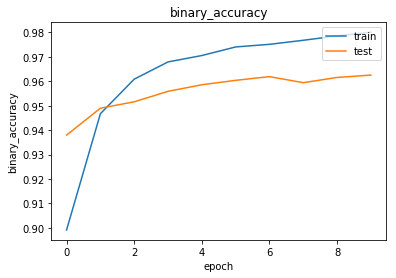

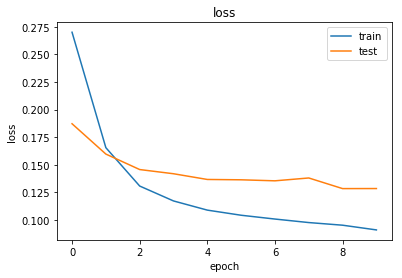

In [48]:
plot_history(history)

Evaluate the trained model on test citation links:

In [656]:
train_metrics = model.evaluate_generator(train_gen)
test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the trained model:
	loss: 0.0827
	binary_accuracy: 0.9819

Test Set Metrics of the trained model:
	loss: 0.1302
	binary_accuracy: 0.9592
